# Radial Velocity Fitting

Notebook to do the necessary fitting of radial velocity data for parameter estimation.
Fitting two free parameters in x and two in y, two of these are nuisance parameters and then aiming to get semi amplitude which will give mass from y and then period from x which we can use in our transit fit. 

Can also aim to calculate and find the rv zero points to find period as that will give the two points of the planet at the start and end of transit because it will have a perpendicular pull on the planet at those points. aim to compute chi square and then say eccentricity is zero and verify circular keplerian orbit. finally, could try to use batman and then try fitting everything simultaneously to see if that works with the transit and radial velocity.

radial velocity has time in BJD−240000, RV (km $s^{-1}$), $\sigma_{RV}$ (km $s^{-1}$)

The error bars on the radial velocities were computed from the cross-correlation function (CCF) using the method presented by Boisse et al. (2010): https://www.aanda.org/articles/aa/full_html/2010/15/aa14909-10/aa14909-10.html.

Spake et al. (2016) does an MCMC fit of photometric data and RV data together to determine planetary parameters, but it does do a preliminary fit of the RV data first to find some quantities I believe.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner

/home/sid/anaconda3/lib/python3.12/site-packages/arviz/__init__.py:39: FutureWarning: 
ArviZ is undergoing a major refactor to improve flexibility and extensibility while maintaining a user-friendly interface.
Some upcoming changes may be backward incompatible.
For details and migration guidance, visit: https://python.arviz.org/en/latest/user_guide/migration_guide.html
  warn(


In [4]:
#RV Data from Spake et al. 2016 

t_rv = np.array([
    56808.4537, 56809.3954, 56810.4489, 56811.4723, 56812.4370,
    56814.3886, 56828.4083, 56829.4019, 56830.4209,
    56856.3802, 56858.3932, 56868.4157, 56870.3629, 56897.4126,
    56899.3859, 56900.3450, 56922.3090, 56932.2772,
    56933.2939
])

rv = np.array([
    -32.017, -32.678, -32.488, -32.010, -32.359,
    -32.102, -32.137, -32.115, -32.651,
    -32.040, -32.653, -32.439, -32.052, -32.532,
    -32.246, -32.663, -32.128, -32.358,
    -31.987
])

rv_err = np.array([
    0.013, 0.010, 0.011, 0.009, 0.019,
    0.010, 0.009, 0.010, 0.009,
    0.010, 0.030, 0.014, 0.009, 0.022,
    0.008, 0.008, 0.008, 0.010,
    0.010
])

In [5]:
# time (days, relative)
t = np.array([
    -6.87055556e-02, -6.80111111e-02, -6.73166667e-02, -6.66222222e-02,
    -6.59277778e-02, -6.52333333e-02, -6.45388889e-02, -6.38444444e-02,
    -6.31500000e-02, -6.24555556e-02, -6.17611111e-02, -6.10666667e-02,
    -6.03722222e-02, -5.96777778e-02, -5.89833333e-02, -5.82888889e-02,
    -5.75944444e-02, -5.69000000e-02, -5.62055556e-02, -5.55111111e-02,
    -5.48166667e-02, -5.41222222e-02, -5.34277778e-02, -5.27333333e-02,
    -5.20388889e-02, -5.13444444e-02, -5.06500000e-02, -4.99555556e-02,
    -4.92611111e-02, -4.85666667e-02, -4.78722222e-02, -4.71777778e-02,
    -4.64833333e-02, -4.57888889e-02, -4.50944444e-02, -4.44000000e-02,
    -4.37055556e-02, -4.30111111e-02, -4.23166667e-02, -4.16222222e-02,
    -4.09277778e-02, -4.02333333e-02, -3.95388889e-02, -3.88444444e-02,
    -3.81500000e-02, -3.74555556e-02, -3.67611111e-02, -3.60666667e-02,
    -3.53722222e-02, -3.46777778e-02, -3.39833333e-02, -3.32888889e-02,
    -3.25944444e-02, -3.19000000e-02, -3.12055556e-02, -3.05111111e-02,
    -2.98166667e-02, -2.91222222e-02, -2.84277778e-02, -2.77333333e-02,
    -2.70388889e-02, -2.63444444e-02, -2.56500000e-02, -2.49555556e-02,
    -2.42611111e-02, -2.35666667e-02, -2.28722222e-02, -2.21777778e-02,
    -2.14833333e-02, -2.07888889e-02, -2.00944444e-02, -1.94000000e-02,
    -1.87055556e-02, -1.80111111e-02, -1.73166667e-02, -1.66222222e-02,
    -1.59277778e-02, -1.52333333e-02, -1.45388889e-02, -1.38444444e-02,
    -1.31500000e-02, -1.24555556e-02, -1.17611111e-02, -1.10666667e-02,
    -1.03722222e-02, -9.67777778e-03, -8.98333333e-03, -8.28888889e-03,
    -7.59444444e-03, -6.90000000e-03, -6.20555556e-03, -5.51111111e-03,
    -4.81666667e-03, -4.12222222e-03, -3.42777778e-03, -2.73333333e-03,
    -2.03888889e-03, -1.34444444e-03, -6.50000000e-04,  4.44444444e-05,
     7.38888889e-04,  1.43333333e-03,  2.12777778e-03,  2.82222222e-03,
     3.51666667e-03,  4.21111111e-03,  4.90555556e-03,  5.60000000e-03,
     6.29444444e-03,  6.98888889e-03,  7.68333333e-03,  8.37777778e-03,
     9.07222222e-03,  9.76666667e-03,  1.04611111e-02,  1.11555556e-02,
     1.18500000e-02,  1.25444444e-02,  1.32388889e-02,  1.39333333e-02,
     1.46277778e-02,  1.53222222e-02,  1.60166667e-02,  1.67111111e-02,
     1.74055556e-02,  1.81000000e-02,  1.87944444e-02,  1.94888889e-02,
     2.01833333e-02,  2.08777778e-02,  2.15722222e-02,  2.22666667e-02,
     2.29611111e-02,  2.36555556e-02,  2.43500000e-02,  2.50444444e-02,
     2.57388889e-02,  2.64333333e-02,  2.71277778e-02,  2.78222222e-02,
     2.85166667e-02,  2.92111111e-02,  2.99055556e-02,  3.06000000e-02,
     3.12944444e-02,  3.19888889e-02,  3.26833333e-02,  3.33777778e-02,
     3.40722222e-02,  3.47666667e-02,  3.54611111e-02,  3.61555556e-02,
     3.68500000e-02,  3.75444444e-02,  3.82388889e-02,  3.89333333e-02,
     3.96277778e-02,  4.03222222e-02,  4.10166667e-02,  4.17111111e-02,
     4.24055556e-02,  4.31000000e-02,  4.37944444e-02,  4.44888889e-02,
     4.51833333e-02,  4.58777778e-02,  4.65722222e-02,  4.72666667e-02,
     4.79611111e-02,  4.86555556e-02,  4.93500000e-02,
], dtype=float)

flux = np.array([
    0.98565958, 0.99294373, 0.99283377, 1.00110954, 0.99552327, 0.99949106,
    0.99848596, 1.00145520, 1.00285730, 1.00595446, 0.99774880, 0.99942303,
    1.00263370, 1.00407008, 1.00264337, 0.99919573, 1.00199523, 0.99432410,
    1.00765569, 0.99834167, 1.00389142, 1.00000000, 0.99977382, 1.00224629,
    1.00026529, 0.99739785, 0.99669758, 0.99441057, 1.00280865, 1.00252988,
    0.98675384, 1.00375521, 0.99373792, 1.00211985, 1.01614583, 1.00722094,
    0.99963354, 0.99528024, 0.99796293, 0.99793371, 1.00530050, 0.99107308,
    1.00247087, 1.01160412, 0.99089096, 0.99016866, 1.01934792, 1.02629287,
    1.02680795, 1.00363327, 0.99734383, 1.00570734, 1.00953893, 1.00410276,
    0.99945755, 0.99969289, 0.99820432, 1.01823947, 0.99850833, 0.98040795,
    0.99509470, 1.00040170, 1.00016283, 0.99530270, 0.99000282, 0.99240342,
    0.98985784, 0.98341506, 0.98909382, 0.98702951, 0.98067519, 0.98434236,
    0.98057561, 0.98077620, 0.98454634, 0.98292108, 0.98329690, 0.98550577,
    0.98289660, 0.98104564, 0.98709135, 0.97618139, 0.97678200, 0.97641691,
    0.97946535, 0.97933727, 0.98138360, 0.98441259, 0.98411459, 0.97693733,
    0.98177496, 0.97954062, 0.97756189, 0.97761290, 0.97902981, 0.98163362,
    0.97677560, 0.97896485, 0.98231251, 0.97747550, 0.98088453, 0.98016232,
    0.98379390, 0.98058080, 0.97953527, 0.97906063, 0.98304494, 0.98259267,
    0.98137292, 0.97995037, 0.98320261, 0.98019567, 0.97203622, 0.98209140,
    0.97804314, 0.98382851, 0.98450880, 0.98155105, 0.98629437, 0.98422774,
    0.98571121, 0.97918831, 0.98104018, 2.19519758, 0.98048009, 0.98445121,
    0.98491926, 0.97934652, 0.98671671, 0.98417909, 0.98501760, 0.98627332,
    0.98974177, 0.98987093, 0.99096602, 0.99488406, 0.99603385, 1.00450302,
    0.99870100, 1.00672300, 0.99468214, 1.00032826, 0.99900843, 1.00074510,
    0.99400903, 0.99018273, 0.99916748, 1.00204695, 0.99794204, 0.99838699,
    0.99674375, 0.99437468, 0.99755854, 0.99796343, 0.99876238, 1.00102638,
    1.00320181, 1.00086334, 1.00836473, 0.99856618, 1.00106983, 0.99021676,
    0.99299954, 0.99611338, 1.00162565, 0.99626099, 0.99553622, 1.00475482,
    1.00002388, 1.01601451, 0.99809844,
], dtype=float)

#drop outlier at ~2.195 
m = flux < 1.5
t, flux = t[m], flux[m]

# estimate uncertainties for the sake of mcmc constant for everything, std of baseline
out_of_transit = np.abs(flux - 1.0) < 0.005 
ferr = np.ones_like(flux) * np.std(flux[out_of_transit])    

In [ ]:
# Cell: RV Model and MCMC Setup (UPDATED)

def rv_model(t, K, gamma, T_c, P):
    """Circular Keplerian RV curve with period as free parameter."""
    phase = 2 * np.pi * (t - T_c) / P
    return K * np.sin(phase) + gamma

def log_probability_rv(theta, t, rv, rv_err):
    K, gamma, T_c, P = theta
    
    # Priors
    if K < 0 or K > 1.0:  # K must be positive, <1 km/s for hot Jupiter
        return -np.inf
    if not (-50 < gamma < -20):  # systemic velocity (your data is around -32 km/s)
        return -np.inf
    # T_c: allow reasonable range
    if not (t.min() - 10 < T_c < t.max() + 10):
        return -np.inf
    # Period: allow variation around literature value
    if not (1.0 < P < 2.0):  # days, centered on ~1.4
        return -np.inf
    
    model = rv_model(t, K, gamma, T_c, P)
    chi2 = np.sum(((rv - model) / rv_err) ** 2)
    return -0.5 * chi2

# Initial guesses
K_guess = (rv.max() - rv.min()) / 2
gamma_guess = np.mean(rv)
T_c_guess = t_rv[np.argmin(np.abs(rv - gamma_guess))]
P_guess = 1.4013776  # start near literature value

initial = np.array([K_guess, gamma_guess, T_c_guess, P_guess])
nwalkers, ndim = 250, 4
pos = initial + 1e-3 * np.random.randn(nwalkers, ndim)

# Run MCMC
sampler_rv = emcee.EnsembleSampler(nwalkers, ndim, log_probability_rv, 
                                    args=(t_rv, rv, rv_err))
sampler_rv.run_mcmc(pos, 10000, progress=True)

samples_rv = sampler_rv.get_chain(discard=1000, thin=10, flat=True)

100%|██████████| 5000/5000 [00:11<00:00, 452.58it/s]


In [7]:
# Cell: Results (UPDATED)

labels_rv = ["K", "gamma", "T_c", "P"]
for i, label in enumerate(labels_rv):
    q16, q50, q84 = np.percentile(samples_rv[:, i], [16, 50, 84])
    print(f"{label} = {q50:.5f} +{q84-q50:.5f} -{q50-q16:.5f}")

K_med = np.median(samples_rv[:, 0])
gamma_med = np.median(samples_rv[:, 1])
T_c_med = np.median(samples_rv[:, 2])
P_med = np.median(samples_rv[:, 3])

# Compare T_c from RV to T0 from transit
# Your transit T0 is relative time ~0, need to convert to same epoch
print(f"\nRV-derived period: {P_med:.6f} days")
print(f"Literature period: 1.4013776 days")

# Chi-squared for circular orbit test
best_rv = rv_model(t_rv, K_med, gamma_med, T_c_med, P_med)
chi2 = np.sum(((rv - best_rv) / rv_err) ** 2)
dof = len(rv) - 4
print(f"\nReduced chi-squared = {chi2/dof:.2f} (should be ~1 for circular orbit)")

K = 0.34777 +0.00348 -0.00343
gamma = -32.33385 +0.00245 -0.00245
T_c = 56899.32821 +0.00282 -0.00279
P = 1.40138 +0.00007 -0.00007

RV-derived period: 1.401379 days
Literature period: 1.4013776 days

Reduced chi-squared = 3.29 (should be ~1 for circular orbit)


IndexError: list index out of range

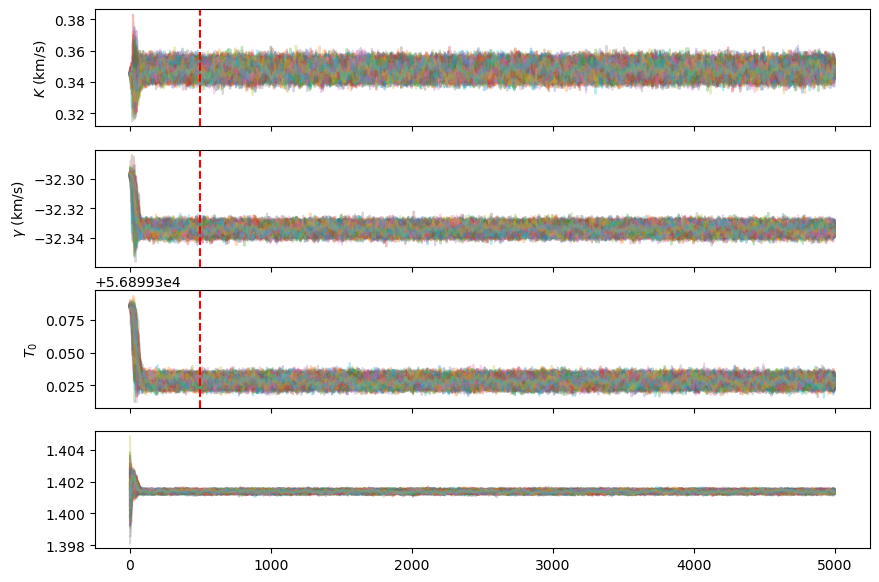

In [10]:
# Cell: Corner Plot and Trace Plot

# Trace plot
chain_rv = sampler_rv.get_chain()
labels_rv = [r"$K$ (km/s)", r"$\gamma$ (km/s)", r"$T_0$"]

fig, axes = plt.subplots(4, 1, figsize=(10, 7), sharex=True)
for i in range(ndim):
    axes[i].plot(chain_rv[:, :, i], alpha=0.3)
    axes[i].set_ylabel(labels_rv[i])
    axes[i].axvline(500, color='r', linestyle='--')
axes[-1].set_xlabel("Step")
plt.tight_layout()
plt.show()

# Corner plot
fig = corner.corner(samples_rv, labels=labels_rv,
                    quantiles=[0.16, 0.5, 0.84], show_titles=True)
plt.show()

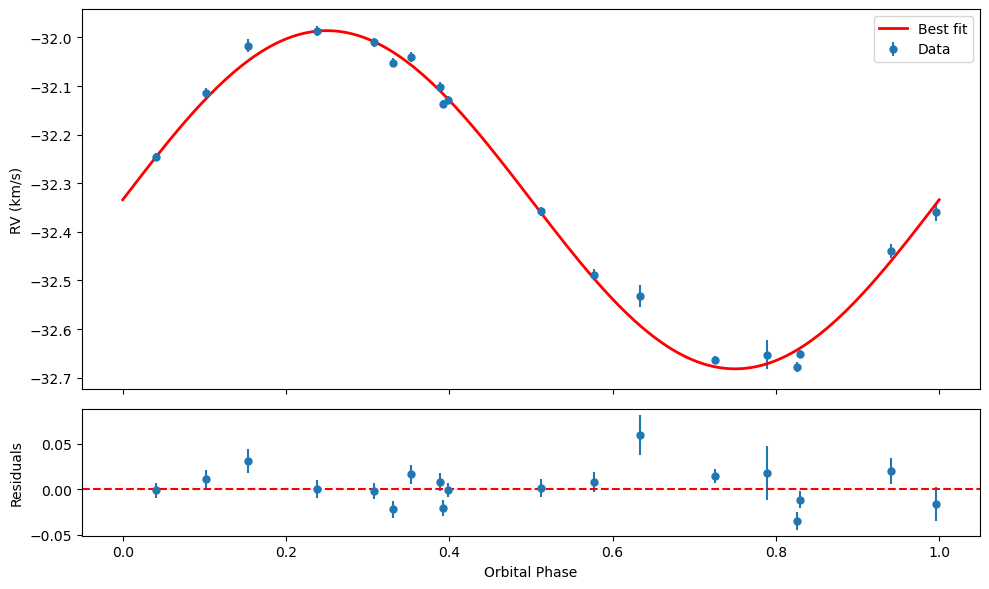

In [39]:
# Phase-folded plot
t_phase = ((t_rv - T0_rv_med) / P_FIXED) % 1
t_model = np.linspace(0, 1, 200)
rv_model_curve = K_med * np.sin(2 * np.pi * t_model) + gamma_med

fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True,
                          gridspec_kw={'height_ratios': [3, 1]})

axes[0].errorbar(t_phase, rv, yerr=rv_err, fmt='o', ms=5, label='Data')
axes[0].plot(t_model, rv_model_curve, 'r-', lw=2, label='Best fit')
axes[0].set_ylabel('RV (km/s)')
axes[0].legend()

# Residuals
rv_model_at_data = rv_model(t_rv, K_med, gamma_med, T0_rv_med)
axes[1].errorbar(t_phase, rv - rv_model_at_data, yerr=rv_err, fmt='o', ms=5)
axes[1].axhline(0, color='r', linestyle='--')
axes[1].set_xlabel('Orbital Phase')
axes[1].set_ylabel('Residuals')

plt.tight_layout()
plt.show()

In [40]:
# Cell: Planet Mass from Semi-Amplitude K

# Constants
G = 6.674e-11       # m^3 kg^-1 s^-2
M_sun = 1.989e30    # kg
R_sun = 6.957e8     # m

# Stellar parameters (WASP-135b from literature)
M_star = 0.98 * M_sun   # kg
R_star = 0.96 * R_sun   # m

# From transit fit
b = 0.8          # impact parameter
aRs = 5.6193       # a/R_star
RpRs = 0.14732     # Rp/R_star

# Convert fitted K to SI units
K_SI = K_med * 1000     # km/s -> m/s
P_SI = P_FIXED * 86400  # days -> seconds

# Inclination from transit geometry: cos(i) = b / (a/Rs)
inc_rad = np.arccos(b / aRs)
inc_deg = np.degrees(inc_rad)

# Planet mass: M_p * sin(i) = K * (P / 2πG)^(1/3) * M_star^(2/3)
Mp_sini = K_SI * (P_SI / (2 * np.pi * G)) ** (1/3) * M_star ** (2/3)
Mp = Mp_sini / np.sin(inc_rad)

# Planet radius from transit depth
Rp = RpRs * R_star

# Output in Jupiter units
print(f"K = {K_med*1000:.1f} m/s")
print(f"Inclination = {inc_deg:.2f} deg")
print(f"M_p sin(i) = {Mp_sini/M_jup:.3f} M_Jup")
print(f"M_p        = {Mp/M_jup:.3f} M_Jup")
print(f"R_p        = {Rp/R_jup:.3f} R_Jup")

K = 347.9 m/s
Inclination = 81.82 deg
M_p sin(i) = 1.890 M_Jup
M_p        = 1.910 M_Jup
R_p        = 1.407 R_Jup


NEED TO FIND STAR MASS FROM COLOURS AND USE THAT HERE TO DETERMINE THE PLANET MASS ESTIMATE FROM RV. 

Are you trying to fit the RV and transit light curve simultaneously? In any case, for the RV fit, you will only be able to uniquely get K_1 and gamma (the RV zero point). You additionally should fit for T_c, and you also get a value for this from the transit light curve (at a different epoch). You also fit for period, which is nominally constrained by the light curve, too, but really only the RVs properly constrain it.
